In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [ ]:
import cv2
# TODO: assert fn exists
def open_image(fn): return cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)

In [ ]:
import matplotlib.pyplot as plt
def show_image(im, ax=None, **kwargs):
    if ax is None: fig,ax = plt.subplots(**kwargs)
    ax.set_axis_off()
    ax.imshow(im)
    return ax

In [ ]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from pycocotools import mask as maskUtils


def showAnns(im, anns, draw_bbox=False, id2cat=None, fontsize=18, ax=None):
    'From github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py#L233'
    if len(anns) == 0:
        return 0
    if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
        datasetType = 'instances'
    elif 'caption' in anns[0]:
        datasetType = 'captions'
    else:
        raise Exception('datasetType not supported')
    if datasetType == 'instances':
        ax = ax or plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        for ann in anns:
            c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
            if 'segmentation' in ann:
                if type(ann['segmentation']) == list:
                    # polygon
                    for seg in ann['segmentation']:
                        poly = np.array(seg).reshape((int(len(seg)/2), 2))
                        polygons.append(Polygon(poly))
                        color.append(c)
                else:
                    # mask
                    width,height,_ = im.shape
                    if type(ann['segmentation']['counts']) == list:
                        rle = maskUtils.frPyObjects([ann['segmentation']], height, width)
                    else:
                        rle = [ann['segmentation']]
                    m = maskUtils.decode(rle)
                    img = np.ones( (m.shape[0], m.shape[1], 3) )
                    if ann['iscrowd'] == 1:
                        color_mask = np.array([2.0,166.0,101.0])/255
                    if ann['iscrowd'] == 0:
                        color_mask = np.random.random((1, 3)).tolist()[0]
                    for i in range(3):
                        img[:,:,i] = color_mask[i]
                    ax.imshow(np.dstack( (img, m*0.5) ))
            if 'keypoints' in ann and type(ann['keypoints']) == list:
                raise NotImplementedError
                # turn skeleton into zero-based index
#                     sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
#                     kp = np.array(ann['keypoints'])
#                     x = kp[0::3]
#                     y = kp[1::3]
#                     v = kp[2::3]
#                     for sk in sks:
#                         if np.all(v[sk]>0):
#                             plt.plot(x[sk],y[sk], linewidth=3, color=c)
#                     ax.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
#                     ax.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

            if draw_bbox:
                [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                np_poly = np.array(poly).reshape((4,2))
                polygons.append(Polygon(np_poly))
                color.append(c)
                name = ann['category_id'] if id2cat is None else id2cat[ann['category_id']]
                ax.text(bbox_x+1, bbox_y-2, name, fontsize=fontsize, color='white', va='bottom',
                        bbox=dict(facecolor=c, edgecolor=c, pad=2, alpha=.9))

        p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)
    elif datasetType == 'captions':
        for ann in anns:
            print(ann['caption'])

In [ ]:
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [ ]:
# initialize COCO api for person keypoints annotations
annKeyFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps=COCO(annKeyFile)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [ ]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
animal outdoor appliance indoor furniture person food electronic sports accessory kitchen vehicle


In [ ]:
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
# imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds = [464689])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [ ]:
imgs = []
anns = []
for iid in imgIds:
    img = coco.loadImgs(iid)[0]
    I = io.imread(img['coco_url'])
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    ann = coco.loadAnns(annIds)
    imgs.append(I)
#     anns[iid] = ann
    anns.extend(ann)

In [ ]:
import json
from pathlib import Path
img_dir = Path('samples/imgs'); img_dir.mkdir(parents=True, exist_ok=True)
with open('samples/annotations.json', 'w') as f:
    json.dump(anns, f)

In [ ]:
for iid,im in zip(imgIds, imgs):
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'samples/imgs/{iid}.jpg', im)

In [ ]:
annIds

[]

In [ ]:
[o['segmentation'] for o in anns]

[[[507.9,
   413.08,
   508.87,
   402.5,
   509.59,
   394.08,
   509.35,
   390.96,
   510.55,
   388.79,
   510.79,
   387.35,
   515.12,
   386.15,
   515.12,
   389.03,
   515.6,
   401.06,
   516.8,
   407.31,
   518.0,
   415.96]],
 [[201.92,
   411.32,
   209.48,
   410.69,
   209.48,
   396.82,
   206.33,
   386.11,
   203.81,
   386.11,
   201.29,
   395.56,
   201.29,
   409.42]],
 [[479.44,
   304.9,
   480.74,
   316.96,
   471.79,
   317.35,
   471.27,
   304.9,
   472.83,
   301.79,
   473.48,
   294.79,
   474.13,
   293.23,
   476.98,
   293.1,
   477.76,
   299.97]],
 [[484.44,
   294.86,
   487.82,
   294.86,
   488.95,
   301.19,
   489.93,
   304.14,
   490.92,
   316.1,
   487.54,
   316.81,
   483.32,
   316.95,
   482.33,
   316.81,
   481.49,
   305.55,
   484.02,
   302.74,
   484.87,
   295.84]],
 [[83.65,
   320.01,
   82.63,
   308.76,
   85.29,
   306.1,
   85.49,
   296.49,
   89.18,
   296.49,
   89.59,
   306.1,
   91.43,
   308.35,
   90.2,
   317.35,


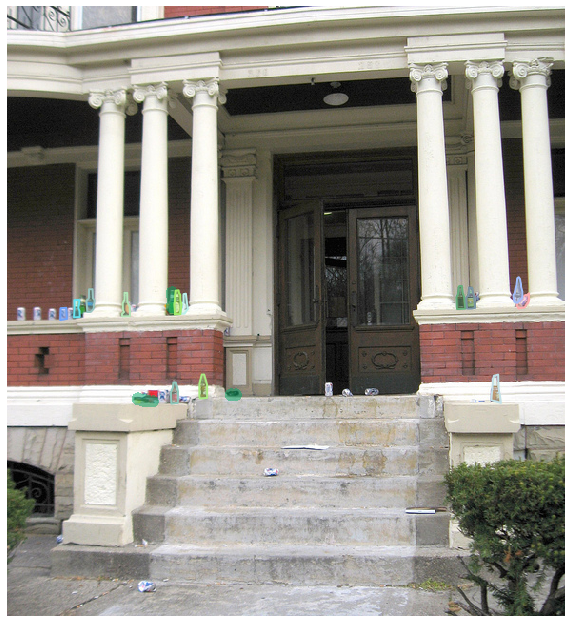

In [ ]:
I = io.imread(img['coco_url'])

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)

ax = show_image(I, figsize=(10,12))
showAnns(I, anns, draw_bbox=False, id2cat=None)

In [ ]:
id2cat = {o['id']:o['name'] for o in cats}

In [ ]:
anns[0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [ ]:
annIds

[10673, 638724, 2162813]

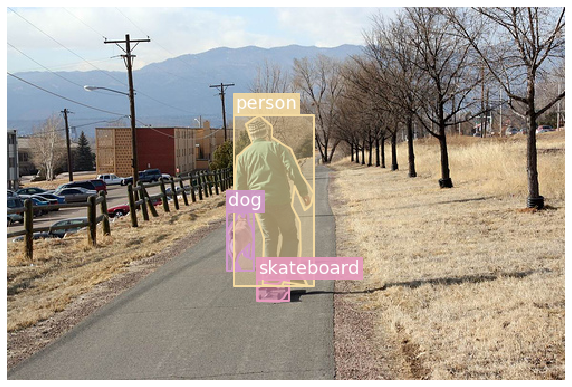

In [ ]:
fig,axs = plt.subplots(nrows=1, figsize=(10,12))
ax = axs
# ax = axs[0]
ax = show_image(I, figsize=(10,12), ax=ax);
# plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True, ax=ax, id2cat=id2cat)
#keypoints
# ax2 = axs[1]
# ax2 = show_image(I, figsize=(10,12), ax=ax2);
# annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco_kps.loadAnns(annIds)
# coco_kps.showAnns(anns, ax=ax2)